# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [ ]:

# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        # dummy assignment until this function is filled in
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)  # output layer for mean
        self.fc22 = nn.Linear(400, 20) # output layer for log probabilities
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)


    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        # dummy assignment until this function is filled in
        means = self.fc21(h).to(device)
        log_variances = self.fc22(h).to(device)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        eps = torch.randn_like(log_variances)
        # dummy assignment until this function is filled in
        embedding = means + eps * torch.exp(log_variances/2)
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        h = F.relu(self.fc3(z))
        # dummy assignment until this function is filled in
        probabilties = torch.sigmoid(self.fc4(h))
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):

        # dummy assignment until this function is filled in
        
        means, log_variances = self.encode(x.view(-1, 784))
        embedding = self.reparameterize(means, log_variances)
        probabilties = self.decode(embedding)
        return probabilties, means, log_variances

# Loss Functions

In [ ]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):

    # dummy assignment until this function is filled in
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    total_loss = KLD + BCE
    return total_loss, BCE


# Training

In [ ]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    model.train()
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        total_loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
        total_loss.backward()
        train_loss += total_loss.item()
        train_BCE += BCE.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                total_loss.item() / len(data)))
    # dummy assignment until this function is filled in
    average_train_loss = train_loss / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_loss))
    return average_train_loss, average_train_BCE



# Testing

In [ ]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
    model.eval()
    # dummy assignment until this function is filled in
    test_loss = 0
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            BCE = dae_loss_function(recon_batch, data)
            KLD = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
            test_loss += BCE + KLD
            test_BCE += BCE.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_loss = test_loss / len(test_loader.dataset)
    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_loss))
    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.073730
Train Epoch: 1 [12800/60000 (21%)]	Loss: 147.548248
Train Epoch: 1 [25600/60000 (43%)]	Loss: 111.719574
Train Epoch: 1 [38400/60000 (64%)]	Loss: 98.521194
Train Epoch: 1 [51200/60000 (85%)]	Loss: 90.623703
====> Epoch: 1 Average loss: 131.2543
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


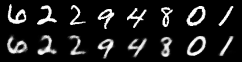

====> Test set loss: 88.0038
Sample of generated images


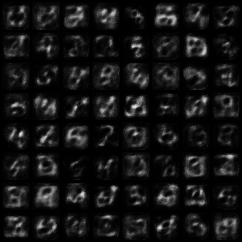



Train Epoch: 2 [0/60000 (0%)]	Loss: 92.839790
Train Epoch: 2 [12800/60000 (21%)]	Loss: 85.323853
Train Epoch: 2 [25600/60000 (43%)]	Loss: 81.701599
Train Epoch: 2 [38400/60000 (64%)]	Loss: 81.166862
Train Epoch: 2 [51200/60000 (85%)]	Loss: 81.048965
====> Epoch: 2 Average loss: 82.4338
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


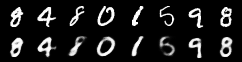

====> Test set loss: 77.7058
Sample of generated images


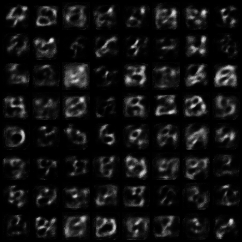



Train Epoch: 3 [0/60000 (0%)]	Loss: 78.763580
Train Epoch: 3 [12800/60000 (21%)]	Loss: 76.508110
Train Epoch: 3 [25600/60000 (43%)]	Loss: 74.010391
Train Epoch: 3 [38400/60000 (64%)]	Loss: 78.611908
Train Epoch: 3 [51200/60000 (85%)]	Loss: 75.355972
====> Epoch: 3 Average loss: 76.5896
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


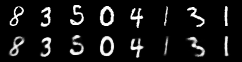

====> Test set loss: 74.4205
Sample of generated images


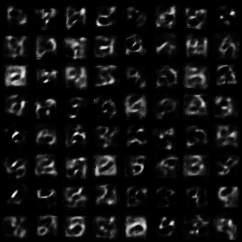



Train Epoch: 4 [0/60000 (0%)]	Loss: 72.142944
Train Epoch: 4 [12800/60000 (21%)]	Loss: 73.351402
Train Epoch: 4 [25600/60000 (43%)]	Loss: 72.673111
Train Epoch: 4 [38400/60000 (64%)]	Loss: 74.017799
Train Epoch: 4 [51200/60000 (85%)]	Loss: 75.534729
====> Epoch: 4 Average loss: 73.9409
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


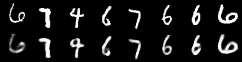

====> Test set loss: 72.2874
Sample of generated images


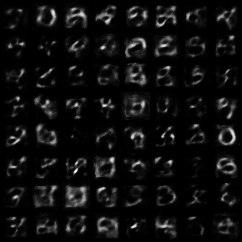



Train Epoch: 5 [0/60000 (0%)]	Loss: 74.773361
Train Epoch: 5 [12800/60000 (21%)]	Loss: 71.864960
Train Epoch: 5 [25600/60000 (43%)]	Loss: 71.842621
Train Epoch: 5 [38400/60000 (64%)]	Loss: 67.674057
Train Epoch: 5 [51200/60000 (85%)]	Loss: 70.090912
====> Epoch: 5 Average loss: 72.2269
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


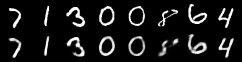

====> Test set loss: 71.1624
Sample of generated images


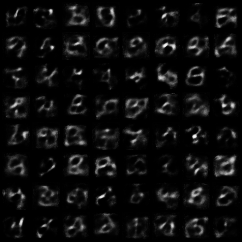



Train Epoch: 6 [0/60000 (0%)]	Loss: 69.492859
Train Epoch: 6 [12800/60000 (21%)]	Loss: 68.759476
Train Epoch: 6 [25600/60000 (43%)]	Loss: 70.112602
Train Epoch: 6 [38400/60000 (64%)]	Loss: 71.765236
Train Epoch: 6 [51200/60000 (85%)]	Loss: 68.891243
====> Epoch: 6 Average loss: 71.0033
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


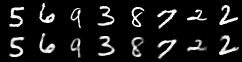

====> Test set loss: 70.2719
Sample of generated images


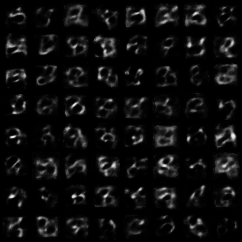



Train Epoch: 7 [0/60000 (0%)]	Loss: 68.972488
Train Epoch: 7 [12800/60000 (21%)]	Loss: 70.835686
Train Epoch: 7 [25600/60000 (43%)]	Loss: 67.562180
Train Epoch: 7 [38400/60000 (64%)]	Loss: 68.522675
Train Epoch: 7 [51200/60000 (85%)]	Loss: 70.202217
====> Epoch: 7 Average loss: 70.0728
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


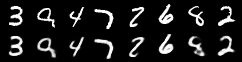

====> Test set loss: 69.3591
Sample of generated images


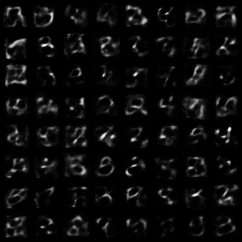



Train Epoch: 8 [0/60000 (0%)]	Loss: 71.429108
Train Epoch: 8 [12800/60000 (21%)]	Loss: 67.276642
Train Epoch: 8 [25600/60000 (43%)]	Loss: 67.091049
Train Epoch: 8 [38400/60000 (64%)]	Loss: 70.374817
Train Epoch: 8 [51200/60000 (85%)]	Loss: 69.499908
====> Epoch: 8 Average loss: 69.3173
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


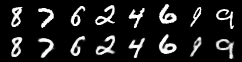

====> Test set loss: 68.7393
Sample of generated images


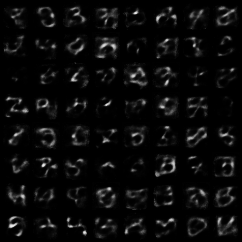



Train Epoch: 9 [0/60000 (0%)]	Loss: 68.070282
Train Epoch: 9 [12800/60000 (21%)]	Loss: 65.615234
Train Epoch: 9 [25600/60000 (43%)]	Loss: 71.093781
Train Epoch: 9 [38400/60000 (64%)]	Loss: 68.821182
Train Epoch: 9 [51200/60000 (85%)]	Loss: 70.159180
====> Epoch: 9 Average loss: 68.7001
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


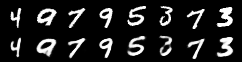

====> Test set loss: 68.3472
Sample of generated images


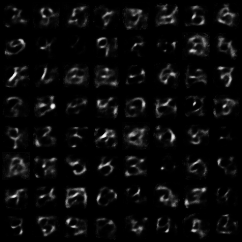



Train Epoch: 10 [0/60000 (0%)]	Loss: 68.653091
Train Epoch: 10 [12800/60000 (21%)]	Loss: 69.592522
Train Epoch: 10 [25600/60000 (43%)]	Loss: 68.705597
Train Epoch: 10 [38400/60000 (64%)]	Loss: 67.542313
Train Epoch: 10 [51200/60000 (85%)]	Loss: 67.799423
====> Epoch: 10 Average loss: 68.1805
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


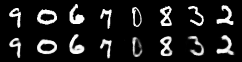

====> Test set loss: 67.9462
Sample of generated images


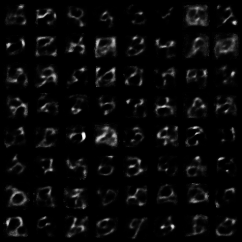



Train Epoch: 1 [0/60000 (0%)]	Loss: 547.910217
Train Epoch: 1 [12800/60000 (21%)]	Loss: 186.761383
Train Epoch: 1 [25600/60000 (43%)]	Loss: 148.940414
Train Epoch: 1 [38400/60000 (64%)]	Loss: 138.977707
Train Epoch: 1 [51200/60000 (85%)]	Loss: 129.842072
====> Epoch: 1 Average loss: 165.0353
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


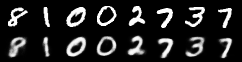

====> Test set loss: 128.1245
Sample of generated images


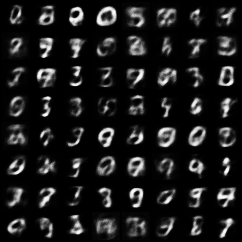



Train Epoch: 2 [0/60000 (0%)]	Loss: 132.575394
Train Epoch: 2 [12800/60000 (21%)]	Loss: 127.726151
Train Epoch: 2 [25600/60000 (43%)]	Loss: 119.459435
Train Epoch: 2 [38400/60000 (64%)]	Loss: 123.459915
Train Epoch: 2 [51200/60000 (85%)]	Loss: 119.473480
====> Epoch: 2 Average loss: 121.6213
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


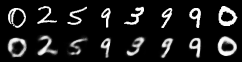

====> Test set loss: 115.6040
Sample of generated images


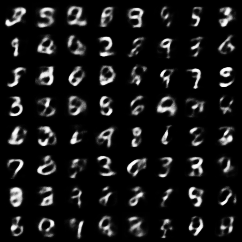



Train Epoch: 3 [0/60000 (0%)]	Loss: 119.623375
Train Epoch: 3 [12800/60000 (21%)]	Loss: 116.533974
Train Epoch: 3 [25600/60000 (43%)]	Loss: 111.926819
Train Epoch: 3 [38400/60000 (64%)]	Loss: 109.622528
Train Epoch: 3 [51200/60000 (85%)]	Loss: 112.692253
====> Epoch: 3 Average loss: 114.3331
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


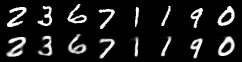

====> Test set loss: 111.7540
Sample of generated images


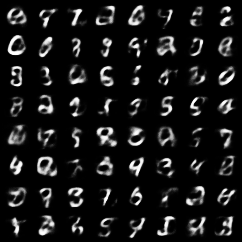



Train Epoch: 4 [0/60000 (0%)]	Loss: 116.259277
Train Epoch: 4 [12800/60000 (21%)]	Loss: 108.707443
Train Epoch: 4 [25600/60000 (43%)]	Loss: 111.187653
Train Epoch: 4 [38400/60000 (64%)]	Loss: 107.082901
Train Epoch: 4 [51200/60000 (85%)]	Loss: 110.552116
====> Epoch: 4 Average loss: 111.3662
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


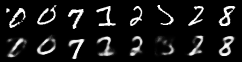

====> Test set loss: 109.5821
Sample of generated images


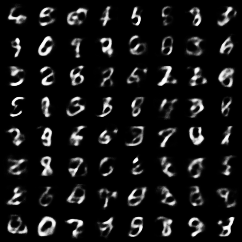



Train Epoch: 5 [0/60000 (0%)]	Loss: 111.734024
Train Epoch: 5 [12800/60000 (21%)]	Loss: 109.776894
Train Epoch: 5 [25600/60000 (43%)]	Loss: 107.032822
Train Epoch: 5 [38400/60000 (64%)]	Loss: 113.093521
Train Epoch: 5 [51200/60000 (85%)]	Loss: 110.570137
====> Epoch: 5 Average loss: 109.6903
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


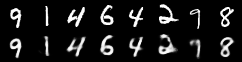

====> Test set loss: 108.3265
Sample of generated images


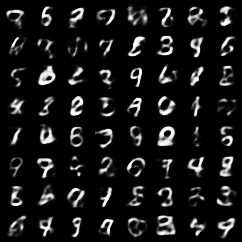



Train Epoch: 6 [0/60000 (0%)]	Loss: 108.800529
Train Epoch: 6 [12800/60000 (21%)]	Loss: 108.664841
Train Epoch: 6 [25600/60000 (43%)]	Loss: 108.194435
Train Epoch: 6 [38400/60000 (64%)]	Loss: 111.527374
Train Epoch: 6 [51200/60000 (85%)]	Loss: 106.323883
====> Epoch: 6 Average loss: 108.5115
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


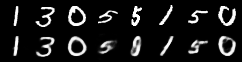

====> Test set loss: 107.4803
Sample of generated images


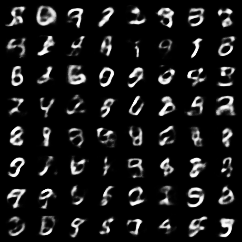



Train Epoch: 7 [0/60000 (0%)]	Loss: 108.328667
Train Epoch: 7 [12800/60000 (21%)]	Loss: 104.710358
Train Epoch: 7 [25600/60000 (43%)]	Loss: 104.986099
Train Epoch: 7 [38400/60000 (64%)]	Loss: 108.172508
Train Epoch: 7 [51200/60000 (85%)]	Loss: 108.977554
====> Epoch: 7 Average loss: 107.7285
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


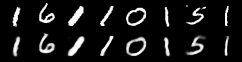

====> Test set loss: 106.8914
Sample of generated images


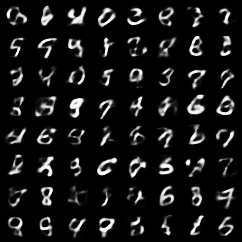



Train Epoch: 8 [0/60000 (0%)]	Loss: 107.282776
Train Epoch: 8 [12800/60000 (21%)]	Loss: 107.431084
Train Epoch: 8 [25600/60000 (43%)]	Loss: 108.918526
Train Epoch: 8 [38400/60000 (64%)]	Loss: 106.299667
Train Epoch: 8 [51200/60000 (85%)]	Loss: 106.996140
====> Epoch: 8 Average loss: 107.0929
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


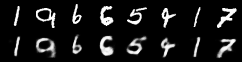

====> Test set loss: 106.4209
Sample of generated images


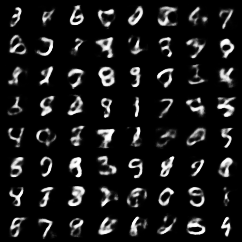



Train Epoch: 9 [0/60000 (0%)]	Loss: 103.828140
Train Epoch: 9 [12800/60000 (21%)]	Loss: 106.749466
Train Epoch: 9 [25600/60000 (43%)]	Loss: 108.068733
Train Epoch: 9 [38400/60000 (64%)]	Loss: 108.803970
Train Epoch: 9 [51200/60000 (85%)]	Loss: 106.631454
====> Epoch: 9 Average loss: 106.5891
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


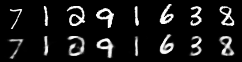

====> Test set loss: 105.9202
Sample of generated images


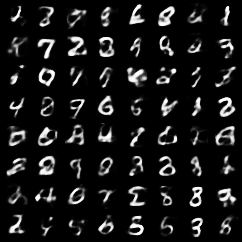



Train Epoch: 10 [0/60000 (0%)]	Loss: 109.432198
Train Epoch: 10 [12800/60000 (21%)]	Loss: 108.394135
Train Epoch: 10 [25600/60000 (43%)]	Loss: 105.883980
Train Epoch: 10 [38400/60000 (64%)]	Loss: 110.331200
Train Epoch: 10 [51200/60000 (85%)]	Loss: 107.100815
====> Epoch: 10 Average loss: 106.2010
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


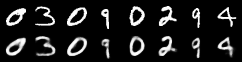

====> Test set loss: 105.4567
Sample of generated images


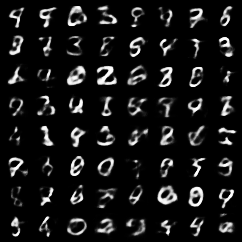

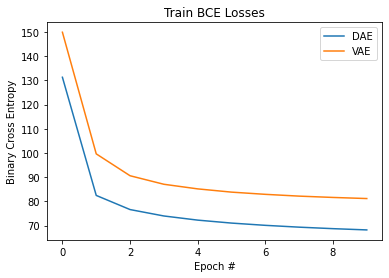

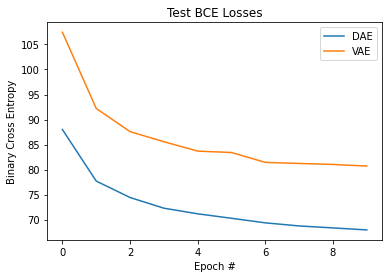

In [ ]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

The DAE is designed to reconstruct input data, and the loss function used to train it is binary cross-entropy. Therefore, the lower the binary cross-entropy loss, the better the DAE model's reconstruction performance.

The VAE is designed to learn a latent representation of the input data and generate new samples from it. The VAE loss function consists of both binary cross-entropy and KL-divergence terms, and the goal is to minimize the sum of these terms. 

So, to compare the performance of the DAE and VAE models, we notice that the DAE has better reconstruction power because of the lower BCE.

 VAE has an overall higher loss than the DAE because it has an additional regularization term in its loss function - the KL divergence term, which encourages the latent variable distribution to be close to a unit Gaussian distribution.Therefore, the VAE has a higher average_train_BCE value too, but this is expected as it is also optimizing for the KL divergence loss.

The VAE's higher loss does not necessarily mean it is performing worse than the DAE, as the VAE is designed to learn a latent representation that can generate new data points by sampling from the learned distribution.
Looking at the new data points sampled from both the VAE and DAE, we see that the VAE clearly outperforms the DAE when it comes to generation.